## Project: Building a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
# Load the modules
import pickle
import math
import random 
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
%matplotlib inline 

In [2]:
# Load pickled data
# TODO: Fill this in based on where you saved the training and testing data

training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

print ('Data loaded')

Data loaded


---
## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [6]:
### Replace each question mark with the appropriate value.
import random

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
index = random.randint(0, len(X_train))

image_shape = X_train[index].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). 

Sample traffic sign of type: 12


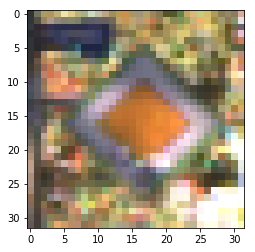

In [7]:
### Display a randomly chosen image
print ("Sample traffic sign of type: {}".format(y_train[index]))
plt.imshow(X_train[index])

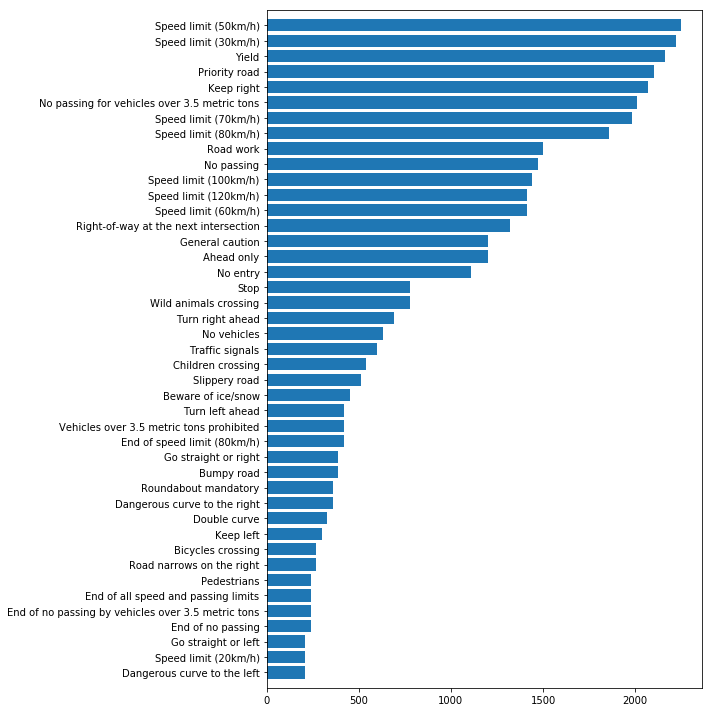

In [8]:
# Exploring the distribution of sign types in the training set 

# Reading the sign names csv into a pandas dataframe
sign_names = pd.read_csv('signnames.csv')

# Creating a dictionary of different sign names counts and putting it into a sorted data frame 
sign_count = {}
for i in range(len(sign_names)):
    sign_count[sign_names['SignName'][i]] = (y_train==sign_names['ClassId'][i]).sum()
sign_count_df = pd.DataFrame.from_dict(sign_count, orient='index', dtype=None)
sign_count_df.columns = ['Count']
sign_count_df_sorted = sign_count_df.sort_values(by='Count', ascending=1)

# Visualizing the distribution 
plt.figure(figsize=(10,10))
plt.barh(range(len(sign_count_df_sorted)), sign_count_df_sorted['Count'], align='center')
plt.yticks(range(len(sign_count_df_sorted)), sign_count_df_sorted.index)
axes = plt.gca()
axes.set_ylim(-1,43)
plt.tight_layout()

----

## Step 2: Design and Test a Model Architecture

In this section I design and implement a deep learning model that learns to recognize traffic signs. I train and test my model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

In [20]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

# Shuffling the training data
X_train, y_train = shuffle(X_train, y_train)

In [21]:
# Create a scaling function 
def min_max_scale(image_data):
    """
    Scale the image data with Min-Max scaling to a range of [-1, 1]
    :param image_data: The image data to be normalized
    :return: scaled image data
    """
    intensity_min = 0
    intensity_max = 255
    return 2*(image_data / (intensity_max - intensity_min)) - 1

In [22]:
# Scale the features 
X_train = min_max_scale(X_train)
X_test = min_max_scale(X_test)

### Preprocessing 

First, I shuffled the data to ensure the integrity of the subsequent splitting out of a validation set. Second, I scaled the data using a simple min-max method, resulting in a range of [-1, 1]. I chose this range, as networks train more efficiently when the mean values of training features are close to zero. 

In [23]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=832289)

print("Final training Set:   {} samples".format(len(X_train)))
print("Validation Set:       {} samples".format(len(X_valid)))
assert(len(X_train)==len(y_train))    
assert(len(X_valid)==len(y_valid))

Final training Set:   25093 samples
Validation Set:       6274 samples


### Choice of training, validation and testing data

I used the simple rule of thumb of 20% for the validation set, as a proportion of the initial training set. I'm going to use the validation set for fine-tuning the model, while keeping the test set untouched until the final one test run. Also, I scaled the features of the test set in the same way as the training (incl. validation) set, to ensure consistency. 

In [24]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x12.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5,5,3,12), mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(12))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1,1,1,1], padding='VALID') + conv1_b

    # TODO: Activation.
    conv1 = tf.nn.relu(conv1)

    # TODO: Pooling. Input = 28x28x12. Output = 14x14x12.
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')

    # TODO: Layer 2: Convolutional. Output = 10x10x24.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5,5,12,24), mean=mu, stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(24))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1,1,1,1], padding='VALID') + conv2_b
    
    # TODO: Activation.
    conv2 = tf.nn.relu(conv2)

    # TODO: Pooling. Input = 10x10x24. Output = 5x5x24.
    conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')

    # TODO: Flatten. Input = 5x5x24. Output = 600.
    fc0 = flatten(conv2)
    
    # TODO: Layer 3: Fully Connected. Input = 600. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(600, 120), mean=mu, stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    
    # TODO: Activation.
    fc1 = tf.nn.relu(fc1)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    
    # TODO: Activation.
    fc2 = tf.nn.relu(fc2)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W = tf.Variable(tf.truncated_normal(shape=(84, 43), mean=mu, stddev=sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Model architecture 

My final architecture is based on LeNet-5, which consists of two convolutional layers, each followed by rectified linear unit (relu) activation function and max pooling and three fully connected layers, also followed by relu activations. I increased the depth of the two convolutional networks to 12 and 24, respectively, to enable capturing richer inputs, as the traffic signs are colored images, hence 3-dimensional arrays, as opposed to grayscale images of handwritten digits. This improved the model accuracy by a couple of percent. More detailed descrition is below: 

* Input 32x32x3, as I'm using colored images
* Convolutional layer, 5x5x3 filter, stride 1 to 28x28x12 output
* Relu
* Maxpool, 2x2 kernel, 2x2 stride 
* Convolutional layer, 5x5x12 filter, stride 1 to 10x10x24 output
* Relu
* Maxpool, 2x2 kernel, 2x2 stride
* Flatten to 600 nodes
* Fully connected layer, 600x120
* Relu
* Fully connected layer, 120x84
* Relu
* Output, 84x43

In [25]:
### Train your model here.
### Feel free to use as many code cells as needed.
# Import TF and set epoch and batch numbers 
import tensorflow as tf

EPOCHS = 10
BATCH_SIZE = 128

In [26]:
# Create placeholdoers for inputs 
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [27]:
# Create training pipeline
rate = 0.005

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [28]:
# Create model evaluation function
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [29]:
# Train the model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.897

EPOCH 2 ...
Validation Accuracy = 0.922

EPOCH 3 ...
Validation Accuracy = 0.907

EPOCH 4 ...
Validation Accuracy = 0.968

EPOCH 5 ...
Validation Accuracy = 0.975

EPOCH 6 ...
Validation Accuracy = 0.978

EPOCH 7 ...
Validation Accuracy = 0.963

EPOCH 8 ...
Validation Accuracy = 0.965

EPOCH 9 ...
Validation Accuracy = 0.964

EPOCH 10 ...
Validation Accuracy = 0.956

Model saved


In [30]:
# Evaluate the model
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.911


### Model training

I decided to use the Adam algorithm optimizer. I read about the Adam method (https://arxiv.org/abs/1412.6980) and noted its computational efficiency properties. I used 10 epochs and no more, as I saw that there were practically no incremental improvements in accuracy after epochs 7-8. I left batch size at 128 for computational efficiency purposes, as I used Amazon EC2 medium instance, not a GPU. The network took about 10 minutes to train. 

I made changes to the initial LeNet-5 model through some reasoning and trial-and-error. For example, I decided to increase the depth of the convolutional layers, because the inputs were colored images and hence richer than, say, grayscale hand-written digits. I used trial-and-error for setting the learning rate. I ended up increasing the rate from 0.001 to 0.005. As I increased it, the performance on the validation set became more erratic and actually somewhat less accurate, however, the accuracy on the test set ended up being better. 

---

## Step 3: Test a Model on New Images

I took several pictures of traffic signs that you find on the web or around you (at least five), and ran them through my classifier on my computer to produce example results. 

In [31]:
# Create an image processing function 
def process_image(raw_image):
    image = cv2.imread(raw_image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (32, 32))
    #image = np.pad(image, ((0,0),(2,2),(2,2),(0,0)), 'constant')
    return image

In [32]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
image1 = process_image('traffic-sign_1.jpg')
image2 = process_image('traffic-sign_2.jpg')
image3 = process_image('traffic-sign_3.jpg')
image4 = process_image('traffic-sign_4.jpg')
image5 = process_image('traffic-sign_6.jpg')
test_photo_array = np.array([image1, image2, image3, image4, image5])

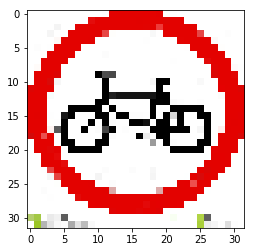

In [33]:
# Displaying two of the signs
plt.imshow(image4)

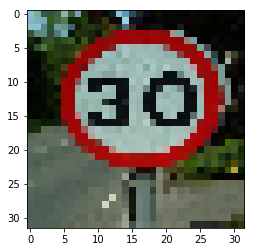

In [34]:
plt.imshow(image5)

In [35]:
# Scalting the features as we did for the training, validation and testing 
test_photo_array = min_max_scale(test_photo_array)

I noticed some differences between the chosen test images and those in the German dataset. These differences can complicate the predictive performance of the model. The main points of difference between the chosen images and the German training / testing dataset are:

* The chosen images are blurred, as the dimensions had to be reduced from hundreds to 32x32
* The actual traffic signs in the chosen images tend to occupy the entire surface of the image, whereas in the big dataset, the signs appear in a relatively small part of the image area. 

In [36]:
### Running predictions
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
photo_array_logits = LeNet(x)
soft = tf.nn.softmax(photo_array_logits)
pred = tf.argmax(soft, 1)
real_values = [14, 17, 28, 29, 1]

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    #sess = tf.get_default_session()
    sess.run(tf.global_variables_initializer())
    softmax_values = sess.run(soft, feed_dict={x: test_photo_array})
    predictions = sess.run(pred, feed_dict={x: test_photo_array})
print("Prediction - classes {}".format(predictions))
print("Real classes {}".format(real_values))
print("Correct / incorrect classifications {}".format(predictions==real_values))

Prediction - classes [32 32 15 15 32]
Real classes [14, 17, 28, 29, 1]
Correct / incorrect classifications [False False False False False]


None of the 5 predictions were correct. The accuracy of the model, judged by its performance on the external 5 images, is zero, compared to 98% and 92% accuracy on the validation and test sets, respectively. 

In [37]:
# Create plotting function
real_sign_names = ['Stop', 'No entry', 'Children crossing', 'Bicycles crossing', 'Speed limit 30']
def plot_bar(i, names, values):
    plt.figure(figsize=(10,10))
    plt.barh(range(len(names)), values[i], align='center')
    plt.yticks(range(len(names)), names['SignName'])
    plt.title(real_sign_names[i])
    axes = plt.gca()
    axes.set_ylim(-1,43)
    plt.tight_layout()

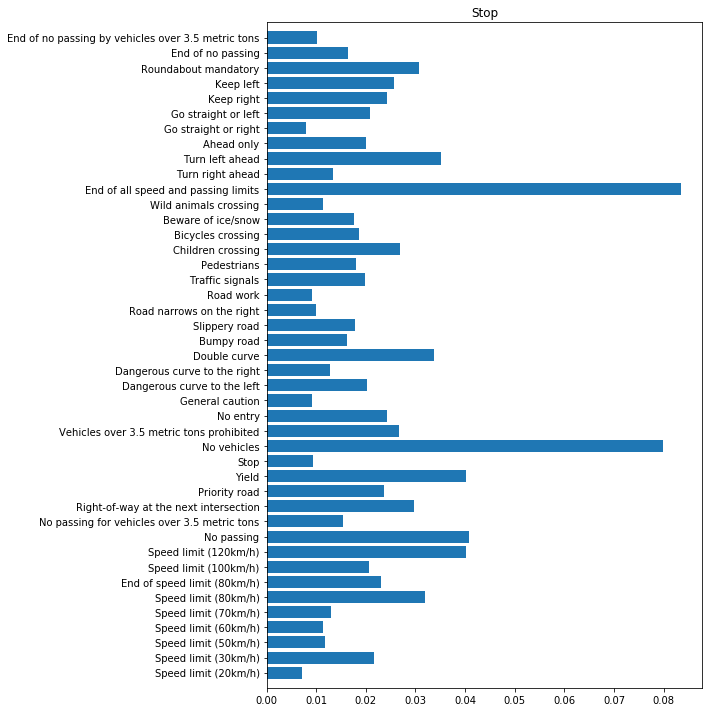

In [38]:
# Plot1
plot_bar(0, sign_names, softmax_values)

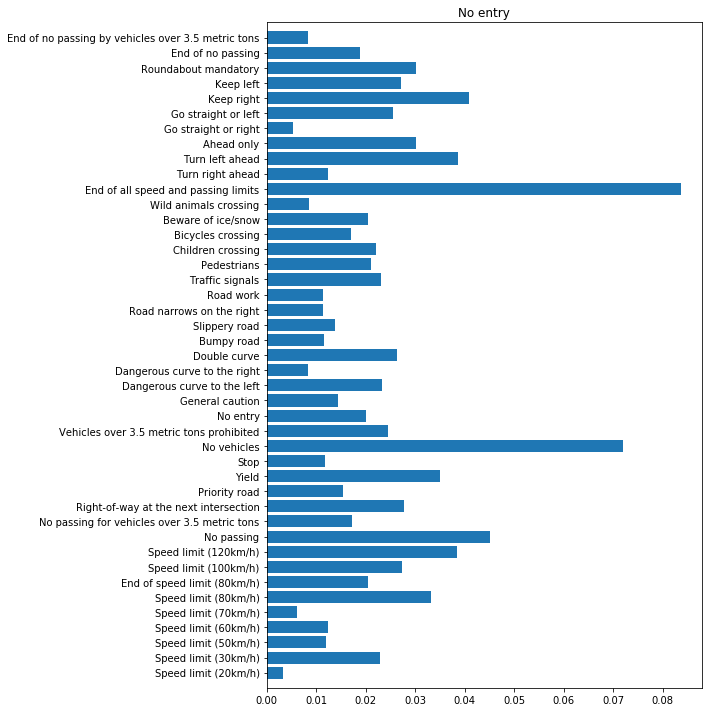

In [39]:
# Plot1
plot_bar(1, sign_names, softmax_values)

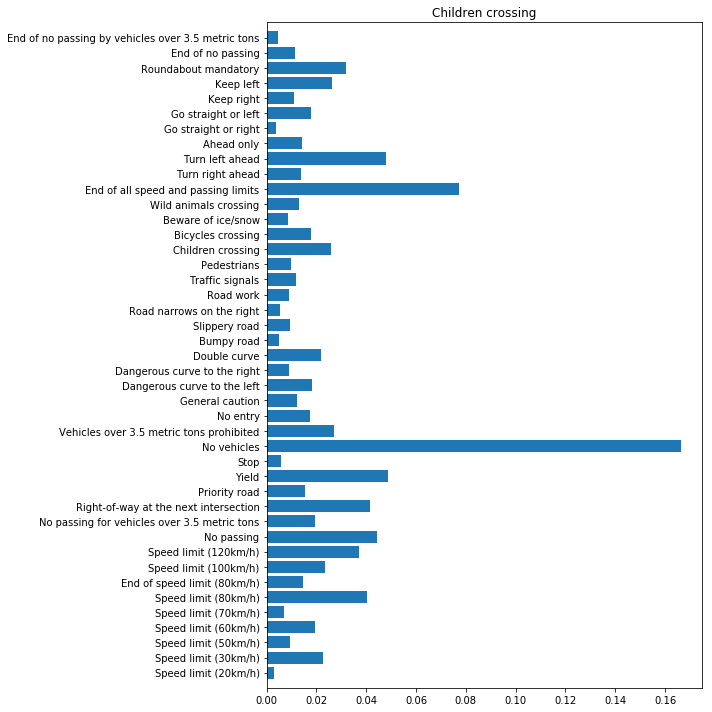

In [40]:
# Plot1
plot_bar(2, sign_names, softmax_values)

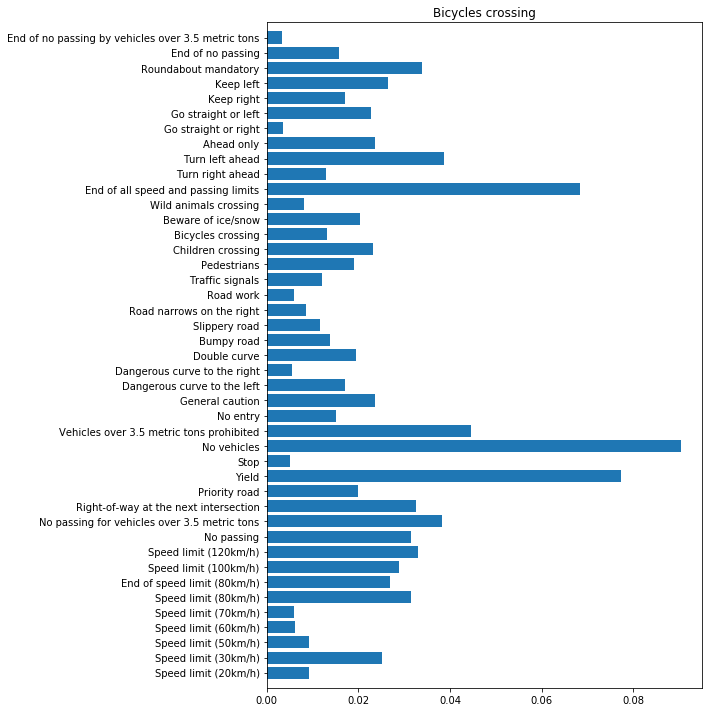

In [41]:
# Plot1
plot_bar(3, sign_names, softmax_values)

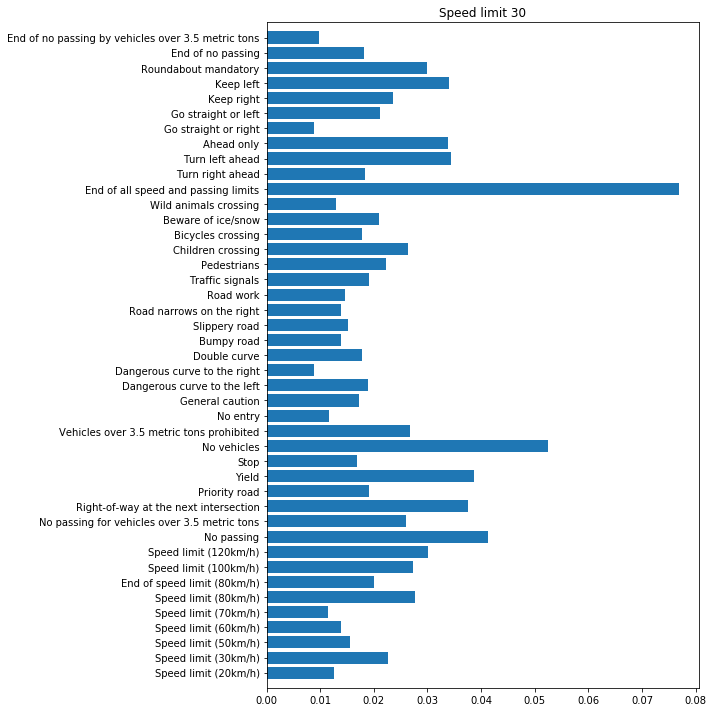

In [42]:
# Plot1
plot_bar(4, sign_names, softmax_values)

### Conclusion

The model performs extremely badly on the external 5 images. As shown below, the correct class does not even appear in the top 5 probabilities for any of the five predictions. This type of extremely poor performance indicates to me that further data preprocessing or model tuning to increase its accuracy on the large test set by a few percent would not improve its peformance on these five images. I think this problem is due to the basic mismatch (see the points in the answer to Q6) between the attributes of the training dataset and the 5 images.

In [43]:
with tf.Session() as sess:
    for i in range(len(softmax_values)):
        print("Real class: ", real_values[i])
        print("Top 5 predicted clases: ", sess.run(tf.nn.top_k(tf.constant(softmax_values[i]), k=5)))

Real class:  14
Top 5 predicted clases:  TopKV2(values=array([ 0.08356572,  0.07996512,  0.04070224,  0.04026255,  0.04011278], dtype=float32), indices=array([32, 15,  9, 13,  8], dtype=int32))
Real class:  17
Top 5 predicted clases:  TopKV2(values=array([ 0.0837485 ,  0.07199454,  0.04520194,  0.0408938 ,  0.03855272], dtype=float32), indices=array([32, 15,  9, 38, 34], dtype=int32))
Real class:  28
Top 5 predicted clases:  TopKV2(values=array([ 0.16654254,  0.07741223,  0.04863894,  0.04810299,  0.04427774], dtype=float32), indices=array([15, 32, 13, 34,  9], dtype=int32))
Real class:  29
Top 5 predicted clases:  TopKV2(values=array([ 0.09050154,  0.07729962,  0.06832854,  0.04461385,  0.03881823], dtype=float32), indices=array([15, 13, 32, 16, 34], dtype=int32))
Real class:  1
Top 5 predicted clases:  TopKV2(values=array([ 0.07681681,  0.0524933 ,  0.04132774,  0.03862182,  0.03747118], dtype=float32), indices=array([32, 15,  9, 13, 11], dtype=int32))
